# Field Phasing and Scaling (Autophase)

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Nicer plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Get field

In [2]:
from pmd_beamphysics import FieldMesh

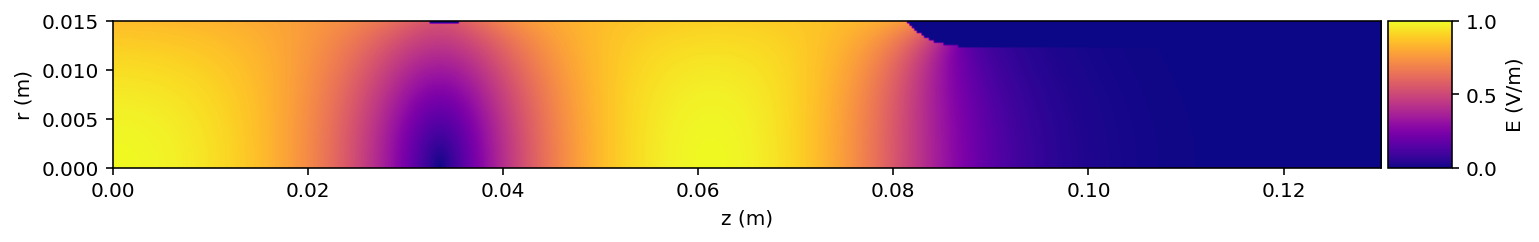

In [3]:
FM = FieldMesh('data/rfgun.h5')
FM.plot(aspect='equal', figsize=(12,8))

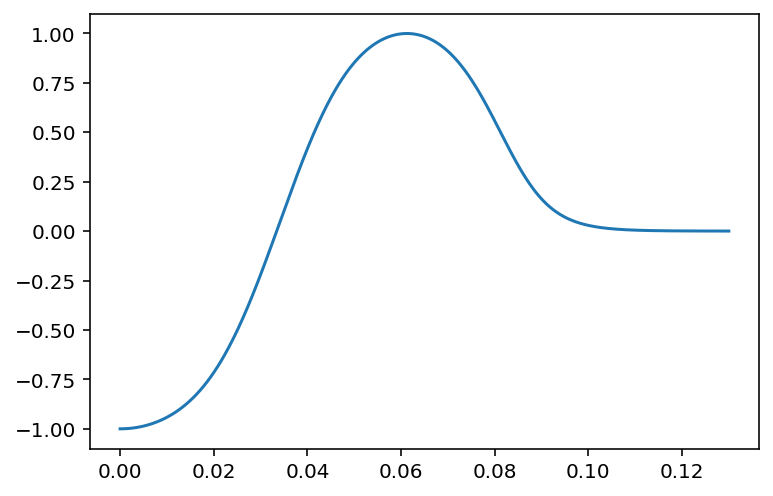

In [4]:
# On-axis field
z0 = FM.coord_vec('z')
Ez0 = FM.Ez[0,0,:]  # this is complex
plt.plot(z0, np.real(Ez0))

# v=c voltage and phase

In [5]:
from pmd_beamphysics.fields.analysis import accelerating_voltage_and_phase

In [6]:
?accelerating_voltage_and_phase

Signature: accelerating_voltage_and_phase(z, Ez, frequency)
Docstring:
Computes the accelerating voltage and phase for a v=c positively charged particle in an accelerating cavity field.

    Z = \int Ez * e^{-i k z} dz 
    
    where k = omega/c = 2*pi*frequency/c
    
    voltage = abs(Z)
    phase = arg(Z)

Input:
    z  (float array):   z-coordinate array (m)
    Ez (complex array): On-axis complex Ez field array (V/m), oscillating as exp(-i omega t), with omega = 2*pi*frequency
    
Output:
    voltage, phase in V, radian
File:      ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/fields/analysis.py
Type:      function


In [7]:
V0, phase0 = accelerating_voltage_and_phase(z0, -Ez0*120e6, FM.frequency)

V0, (phase0 * 180/np.pi) % 360

(5795904.446882586, 322.1355626180106)

# Tracking

Equations of motion:

$\frac{dz}{dt} = \frac{pc}{\sqrt{(pc)^2 + m^2 c^4)}} c$ 

$\frac{dp}{dt} = q E_z $

$E_z = \Re f(z) \exp(-i \omega t) $

In [8]:
from pmd_beamphysics.fields.analysis import track_field_1d
from pmd_beamphysics.units import mec2, c_light

In [9]:
?track_field_1d

Signature:
track_field_1d(
    z,
    Ez,
    frequency=0,
    z0=0,
    pz0=0,
    t0=0,
    mc2=510998.94999999995,
    q0=-1,
    debug=False,
    max_step=inf,
)
Docstring:
Tracks a particle in a 1d complex electric field Ez, oscillating as Ez * exp(-i omega t)

Uses scipy.integrate.solve_ivp to track the particle. 

Equations of motion:

$ rac{dz}{dt} = rac{pc}{\sqrt{(pc)^2 + m^2 c^4)}} c $ 

$ rac{dp}{dt} = q E_z $

$ E_z = \Re f(z) \exp(-i \omega t) $


Parameters
----------
z : array_like      
    positions of the field Ez (m)
Ez : array_like, complex
    On-axis longitudinal electric field (V/m)
    
z0 :  float, optional = 0
    initial particle position (m)
pz0 : float, optional = 0
    initial particle momentum (eV/c)
t0 : float, optional = 0
    initial particle time (s)
mc2 : float, optional = mec2
    initial particle mass (eV)
q0 : float, optional = -1
    initial particle charge (e) (= -1 for electron)
max_step: float, optional = np.inf
    Maximum timestep for sol

In [10]:
Z = FM.coord_vec('z')
E = FM.Ez[0,0,:]*np.exp(1j*2*np.pi /360 * 0)*120e6 

# Final z (m) and pz (eV/c)
track_field_1d(Z, E, FM.frequency, pz0=0, t0=0)

(0.13000001229731464, 3896770.379803205)

In [11]:
# Use debug mode to see the actual track
sol = track_field_1d(Z, E, FM.frequency, pz0=0, t0=0, debug=True, max_step=1/FM.frequency/100)

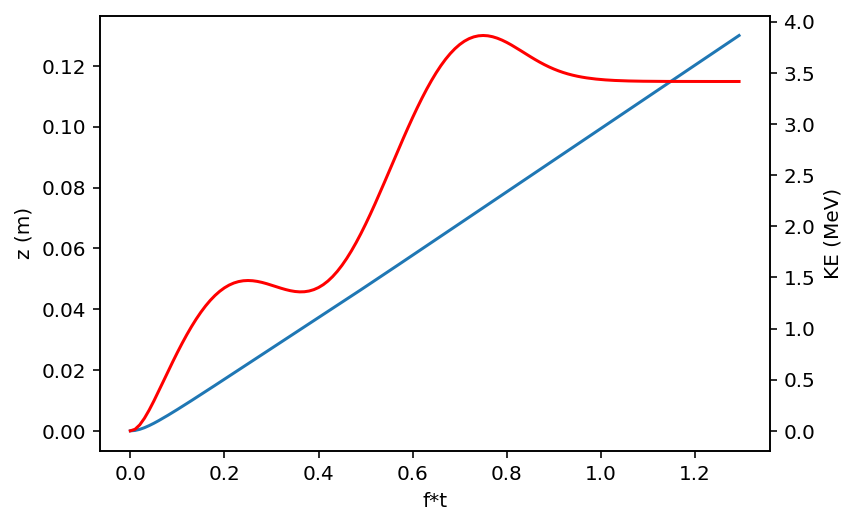

In [12]:
# Plot the track
fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.set_xlabel('f*t')
ax.set_ylabel('z (m)')
ax2.set_ylabel('KE (MeV)')

ax.plot(sol.t*FM.frequency, sol.y[0])
ax2.plot(sol.t*FM.frequency, (np.hypot(sol.y[1], mec2)-mec2)/1e6, color='red')

# Autophase

In [13]:
from pmd_beamphysics.fields.analysis import autophase_field

In [14]:
phase_deg1, pz1 = autophase_field(FM, pz0=0, scale=120e6, verbose=True)
phase_deg1, pz1 

v=c voltage: 5795904.446882586 V, phase: -37.86443738198939 deg
    iterations: 19
    function calls: 24


(304.3348289439232, 6234145.795778026)

In [15]:
# Use debug mode to visualize. This returns the phasiing function
phase_f = autophase_field(FM, pz0=0, scale=120e6, debug=True)
phase_f(304.3348289439232)

6234145.795778026

Text(0, 0.5, 'pz (MeV/c)')

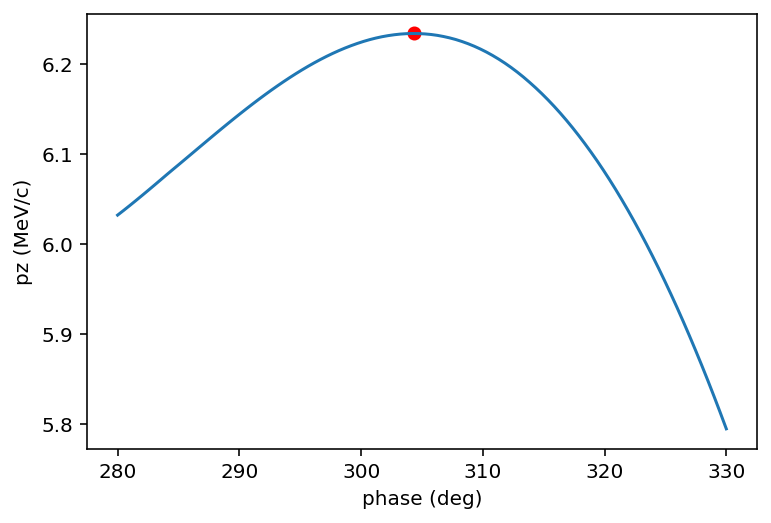

In [16]:
plist = np.linspace(280, 330, 100)
pzlist = np.array([phase_f(p) for p in plist])

plt.plot(plist, pzlist/1e6)
plt.scatter(phase_deg1, pz1/1e6, color='red')
plt.xlabel('phase (deg)')
plt.ylabel('pz (MeV/c)')

# Autophase and Scale

In [17]:
from pmd_beamphysics.fields.analysis import autophase_and_scale_field
?autophase_and_scale_field

Signature:
autophase_and_scale_field(
    field_mesh,
    voltage,
    pz0=0,
    species='electron',
    debug=False,
    verbose=False,
)
Docstring:
Finds the maximum accelerating of a FieldMesh.

Uses two iterations of phasing, scaling.

Parameters
----------
fieldmesh : FieldMesh object

voltage : float
    Desired on-crest voltage in V
    
pz0 : float, optional = 0 
    initial particle momentum in the z direction, in eV/c
    pz = 0 is a particle at rest. 

species : str, optional = 'electron'
    species to track.
    
debug : bool, optional = False
    If true, will return a function that tracks the field at a given phase and scale.
    
verbose : bool, optional = False
    If true, prints information about the v=c voltage and phase for the initial guess, and function call information.
    
Returns
-------
phase : float
    Maximum accelerating phase in deg
scale : float        
    scale factor for the field      
File:      ~/Code/GitHub/openPMD-beamphysics/pmd_beamphysics/f

In [18]:
phase_deg2, scale2 = autophase_and_scale_field(FM, 6e6, pz0=0, verbose=True)
phase_deg2, scale2

v=c voltage: 0.048299203724021564 V, phase: -37.86443738198939 deg
    Pass 1 delta energy: 6000000.288678137 at phase  304.97862629915215 deg
    Pass 2 delta energy: 5999999.999982758 at phase  305.14631151804383 deg


(305.14631151804383, 125273551.27124605)

In [19]:
# Use debug mode to visualize. This returns the phasing function
ps_f = autophase_and_scale_field(FM, 6e6, pz0=0, debug=True)
ps_f(phase_deg2, scale2)

5999999.999982758

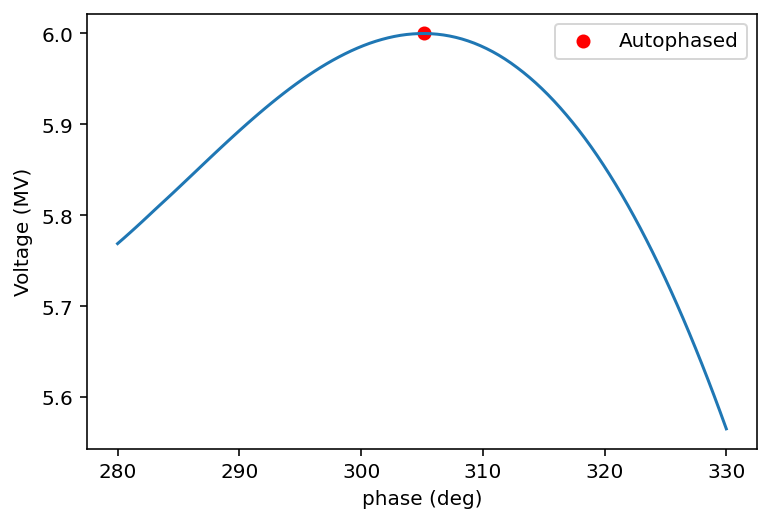

In [20]:
plist = np.linspace(280, 330, 100)
denergy = np.array([ps_f(p, scale2) for p in plist])

plt.plot(plist, denergy/1e6)
plt.scatter(phase_deg2, ps_f(phase_deg2, scale2)/1e6, color='red', label='Autophased')
plt.xlabel('phase (deg)')
plt.ylabel('Voltage (MV)')
plt.legend()